# Inventory Segmentation and Shipment Prediction
## *Inventory (ABC-XYZ) Clustering and Shipment Risk Prediction with Machine Learning*
### *Mini Project 2*
> Author: Ng Soo Kuan

### **Business Problems and Understanding**

- Supply Chain Department would like to optmize the inventory and shipment cost due to recent increase of inventory holding cost and shipment cost.
- Currently there is no segmentation on inventory, all the shipment ship as usual. Extra cost incur especially on those products that generate lower revenue and unstable demand. Money spend to expedite the shipment and there is no consolidate shipment.
- Unforesee shipment delay happened may have revenue impact and customer complaints.

### **Proposed Solution by Using Machine Learning Method**

- ABC-XYZ classification helps businesses optimize inventory management by prioritizing what to stock, how much to stock, and how often to reorder, based on value (ABC) and demand variability (XYZ).
- This project will combine unsupervise learning (K-Mean) clustering with ABC-XYZ concepts. It can serves as automated solution if there are new products or new features added into the scope.
- Applied Machine Learning method on another dataset to predict the risk of shipment delay. It can help logistic team to focus on expediting the shipment based on priority cluster.

### **Data Understanding**
#### *This project will use 2 dataset. First for KMean Clustering, another dataset is for shipment delay risk prediction by using machine learning.*

> 1. KMeans Clustering Dataset
#### **Dataset:** *https://www.kaggle.com/code/shahriarkabir/abc-xyz-inventory-classification*
- **Item_ID:** Unique item identifier
- **Item_Name:** Product name (e.g., "Wireless Headphones", "Winter Jacket")
- **Category:** Product category
- **Jan_Demand until Dec_Demand:** Monthly unit sales
- **Total_Annual_Units:** Total units sold in a year
- **Price_Per_Unit:** USD price per unit
- **Total_Sales_Value:** Annual revenue (Total_Annual_Units * Price_Per_Unit)

> 2. Shipment Risk Dataset
#### **Dataset:** *https://www.kaggle.com/code/sasakitetsuya/logistics-delay-risk-assessment/input*
- **Timestamp:** Timestamp for the latest shipment status
- **Asset_ID:** Truck ID
- **Latitude:** Shipment Location
- **Longitude:** Shipment Location
- **Inventory_Level:** Inventory level of the product
- **Temperature:** Environment factor temperature
- **Humidity:** Environment factor humidity
- **Traffic_Status:** Current Shipment Status
- **Waiting_Time:** Time a shipment spends in transit or at checkpoints.
- **User_Transaction_Amount:** Customer payment transaction on the shipment
- **User_Purchase_Frequency:** Customer purchase frequency
- **Logistics_Delay_Reason:** The reason of the shipment delay
- **Asset_Utilization:** The utilization of the fleet
- **Demand_Forecast:** Demand forecast of the product
- **Logistics_Delay:** Delayed (1) or on-time (0)

## 1. Inventory (ABC_XYZ) Clustering by using KMeans

### *Import the Libraries*

In [2]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from string import ascii_letters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LearningCurveDisplay
from sklearn.svm import SVC

## Avoid some version change warnings
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

# Set the default figure size
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)

### *Import the Dataset*

In [4]:
inv = pd.read_csv('abc_xyz_dataset.csv', index_col = False)
print(inv.head())

   Item_ID      Item_Name Category  Jan_Demand  Feb_Demand  Mar_Demand  \
0  ITM_001   Surface Near  Grocery        4516        4069        4664   
1  ITM_002    Central Him  Grocery        4792        4964        4628   
2  ITM_003   Win Everyone  Apparel          61         175          38   
3  ITM_004      Task Save  Apparel        1145        1113         717   
4  ITM_005  Hotel Teacher  Grocery        1494        2051        1400   

   Apr_Demand  May_Demand  Jun_Demand  Jul_Demand  Aug_Demand  Sep_Demand  \
0        4653        4508        4125        4669        4210        4824   
1        4660        4897        5015        4805        4686        4896   
2          43          15         161         224          41         387   
3         832         783         954        1047         894         994   
4        1918        1669        1733        1695        1560        1679   

   Oct_Demand  Nov_Demand  Dec_Demand  Total_Annual_Units  Price_Per_Unit  \
0        4497  

### *Exploratory Data Analysis*

In [6]:
# Check the Column and row size 
inv.shape

(1000, 18)

In [7]:
# Check the data type and info (missing value)
inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Item_ID             1000 non-null   object
 1   Item_Name           1000 non-null   object
 2   Category            1000 non-null   object
 3   Jan_Demand          1000 non-null   int64 
 4   Feb_Demand          1000 non-null   int64 
 5   Mar_Demand          1000 non-null   int64 
 6   Apr_Demand          1000 non-null   int64 
 7   May_Demand          1000 non-null   int64 
 8   Jun_Demand          1000 non-null   int64 
 9   Jul_Demand          1000 non-null   int64 
 10  Aug_Demand          1000 non-null   int64 
 11  Sep_Demand          1000 non-null   int64 
 12  Oct_Demand          1000 non-null   int64 
 13  Nov_Demand          1000 non-null   int64 
 14  Dec_Demand          1000 non-null   int64 
 15  Total_Annual_Units  1000 non-null   int64 
 16  Price_Per_Unit      1000 

In [8]:
# Check duplicated record
inv.duplicated().sum()

0

### *Inventory ABC Classification*
> ABC classification is based on annual consumption value (Total_Annual_Units * Price_Per_Unit). In this case, we can obtain the Total_Sales_Value as our ABC classification.

### *Inventory XYZ Classification*
> This classifies inventory by how predictable or stable the demand is. Need apply feature engineering to obtain this value. It can calculate by this Coefficient of Variation (CV) formula: **Standard Deviation (Demand) /Mean (Demand)**
- X → CV ≤ 0.1 → stable demand
- Y → 0.1 < CV ≤ 0.25 → moderate variability
- Z → CV > 0.25 → high variability

### *Feature Engineering*

In [12]:
# Drop the columns that not needed for Clustering ('Item_Name', 'Category', 'Total_Annual_Units', 'Price_Per_Unit')
inv = inv.drop(['Item_Name', 'Category', 'Total_Annual_Units', 'Price_Per_Unit'], axis=1)
inv.head()

,Item_ID,Jan_Demand,Feb_Demand,Mar_Demand,Apr_Demand,May_Demand,Jun_Demand,Jul_Demand,Aug_Demand,Sep_Demand,Oct_Demand,Nov_Demand,Dec_Demand,Total_Sales_Value
0,ITM_001,4516,4069,4664,4653,4508,4125,4669,4210,4824,4497,4259,4782,537760
1,ITM_002,4792,4964,4628,4660,4897,5015,4805,4686,4896,4536,4520,5054,5745300
2,ITM_003,61,175,38,43,15,161,224,41,387,340,70,21,3152
3,ITM_004,1145,1113,717,832,783,954,1047,894,994,978,1136,712,22610
4,ITM_005,1494,2051,1400,1918,1669,1733,1695,1560,1679,1381,1591,1662,198330


In [13]:
# Change the wide table to long
inv = inv.drop_duplicates()
long_inv = pd.melt(inv,
                  id_vars=['Item_ID','Total_Sales_Value'],       # columns to keep fixed
                  var_name='Month',         # new column for former column names
                  value_name='Demand')       # new column for values

print(long_inv.head())

   Item_ID  Total_Sales_Value       Month  Demand
0  ITM_001             537760  Jan_Demand    4516
1  ITM_002            5745300  Jan_Demand    4792
2  ITM_003               3152  Jan_Demand      61
3  ITM_004              22610  Jan_Demand    1145
4  ITM_005             198330  Jan_Demand    1494


In [14]:
# Check the table format whether correct.
long_inv[long_inv['Item_ID']=='ITM_001']

,Item_ID,Total_Sales_Value,Month,Demand
0,ITM_001,537760,Jan_Demand,4516
1000,ITM_001,537760,Feb_Demand,4069
2000,ITM_001,537760,Mar_Demand,4664
3000,ITM_001,537760,Apr_Demand,4653
4000,ITM_001,537760,May_Demand,4508
5000,ITM_001,537760,Jun_Demand,4125
6000,ITM_001,537760,Jul_Demand,4669
7000,ITM_001,537760,Aug_Demand,4210
8000,ITM_001,537760,Sep_Demand,4824
9000,ITM_001,537760,Oct_Demand,4497


In [15]:
# Calculate the Cofficient of Variance, CV
# Group by Item_ID and Total Sales Value
X = long_inv.groupby(['Item_ID','Total_Sales_Value'])['Demand'].agg(['mean', 'std']).reset_index()

# Compute Coefficient of Variation
X['cv'] = X['std'] / X['mean']
print(X)

     Item_ID  Total_Sales_Value         mean         std        cv
0    ITM_001             537760  4481.333333  257.272524  0.057410
1    ITM_002            5745300  4787.750000  182.115410  0.038038
2    ITM_003               3152   131.333333  127.696610  0.972309
3    ITM_004              22610   942.083333  155.640879  0.165209
4    ITM_005             198330  1652.750000  193.900689  0.117320
..       ...                ...          ...         ...       ...
995  ITM_995             291610  2430.083333  117.672472  0.048423
996  ITM_996              98510  4104.583333  171.768056  0.041848
997  ITM_997            1984450  3307.416667  221.233508  0.066890
998  ITM_998               3898   162.416667  118.861614  0.731831
999  ITM_999             205550   342.583333   14.304852  0.041756

[1000 rows x 5 columns]


In [16]:
# Start Clustering by using Total Sale Value (ABC) and cv (XYZ)
## Create some supporting functions

# Create new centroids randomly for all the K clusters including all dimensions
def create_centroids(K, features):
    # start with No centroids
    centroids = []
    # need one centroid for each cluster
    for i in range(K):
        # it can be multi-dimensional
        dimensions = []
        for f in features:
            # create a random number between the minimum and maximum of each feature
            x = np.random.uniform(X[f].min(), X[f].max()) #
            dimensions.append(x)
        # add all dimensions for the centroids of each cluster
        centroids.append(dimensions)

    return centroids

In [17]:
# Segmentation on debt_to_income_ratio and savings_to_income_ratio
centroids = create_centroids(3, ['Total_Sales_Value', 'cv'])
centroids

[[27019131.705557227, 0.7982735835643615],
 [42875006.85460661, 0.897608573676044],
 [15440203.411925312, 0.5448190869567384]]

In [18]:
# Identify the closest centroid for a given data point
def closest_centroid(x, centroids):
    distances = []
    # convert x to a numpy.array; x contains all the features of a data point
    p = np.array(x)
    for c in centroids:
        # convert c to a numpy.array; c contains the coordinates for all the features
        q = np.array(c)
        # calculate the Euclidean distance between data point `x` and centroid `c`
        d = np.sqrt(np.square(p-q).sum())
        # Hint: consider that the data has been converted to NumPy Arrays
        # add the distance for each centroid
        distances.append(d)

    # return the position (cluster) which has the smallest distance
    return np.array(distances).argmin()

In [19]:
# recalculate all the centroids based on the mean of the members of each cluster
def update_centroid(X, y, centroids):
    c = []
    # for each of the existing centroids
    for i in range(len(centroids)):
        # check if any object was assigned to a cluster
        if X[y == i].shape[0]:
            dimensions = []
            # for all the features
            for f in X.columns:
                # calculate the mean
                x = X[f][y == i ].mean() #
                dimensions.append(x)
            c.append(dimensions)
        # if a cluster got no members
        else:
            # keep the previous coordinates
            c.append(centroids[i]) #

    return c

In [20]:
# plot a chart of the data points and centroids either generic or identifying the clusters
# NOTE: for visualisation purposes, only consider the first two features
def plot_data(ax, X, y, centroids, show_clusters = True):
    # unpack the coordinates of the centroids
    a = [z[0] for z in centroids]
    b = [z[1] for z in centroids]

    # show distinct colours if asked to identify the clusters
    if show_clusters:
        colours = 'rgbykcm'
        for i in range(len(centroids)):
            ax.scatter(X[features[0]][y == i], X[features[1]][y == i], c = colours[i], label = 'Cluster %d' % i)
    # show data points without cluster identification
    else:
        ax.scatter(X[features[0]], X[features[1]], label = 'Data Point')

    # label the features
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

    # identify the centroids
    ax.scatter(a, b, c = 'k', linewidths = 5, marker = 'x', label = 'Centroid')
    for i in range(len(a)):
        c = colours[i] if show_clusters else 'k'
        ax.axvline(x = a[i], color = c, linestyle = '--', linewidth = 1)
        ax.axhline(y = b[i], color = c, linestyle = '--', linewidth = 1)

    # create a text to show the centroids' coordinates
    t = '\n'.join(['%d: (%.3f, %.3f)' % (i, a, b) for (i, (a, b)) in enumerate(centroids)])
    ax.text(7.2, 1, t)

    ax.legend()

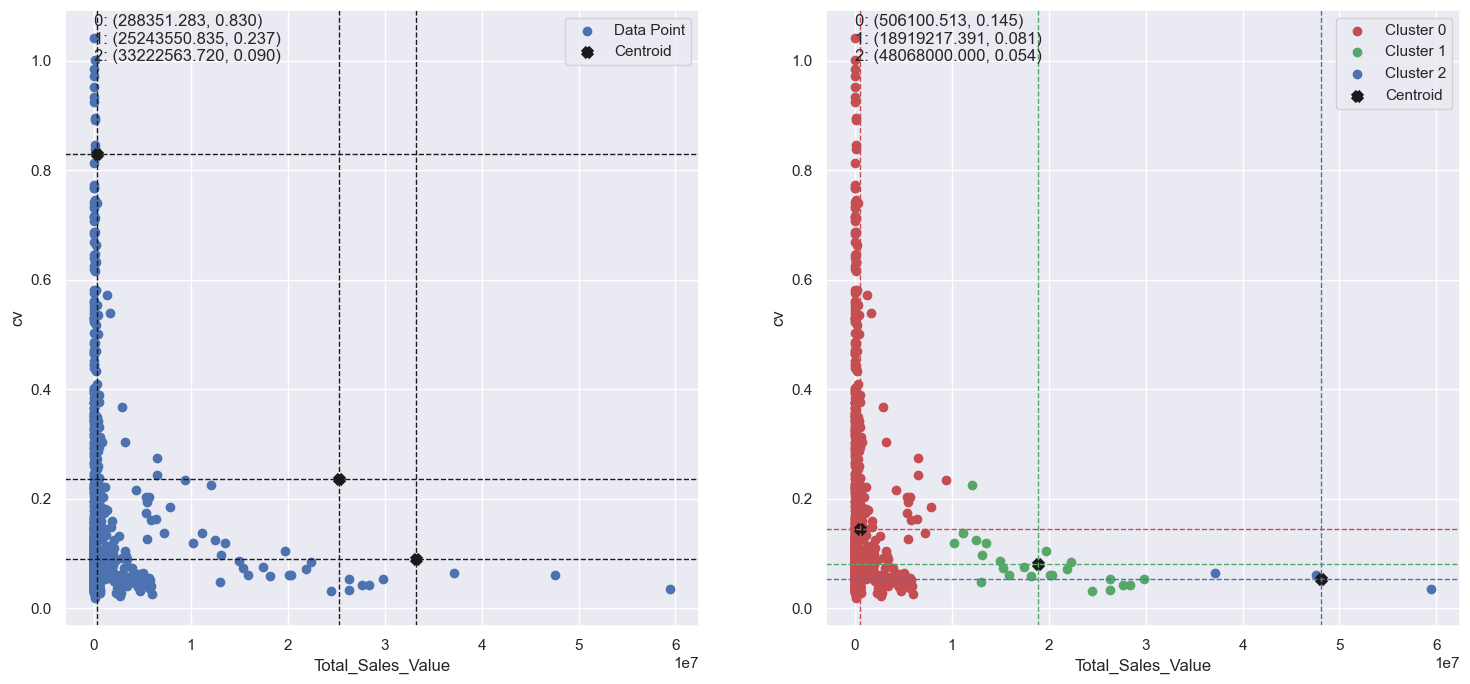

In [21]:
## K_Means
## Note that the comments match the outlined K-Means Algorithm in the presentation

# 1. Define the number of clusters `K`
K = 3

# list the features to be used
features = ['Total_Sales_Value', 'cv']

# 2. Select `K` cluster centres randomly
centroids = create_centroids(K, features)
centroids_list = [centroids] # Create the initial centroids

# plot the data points and initial centroids (the 'Before')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
plot_data(axes[0], X[features], None, centroids, False)

# repeat util makes no moves
while True:
    # 3. Calculate the distance between each data point and cluster centres
    # 4. Assign the data point to the cluster whose distance from its centre is minimum

    y = X[features].apply(lambda x: closest_centroid(x, centroids), axis = 1).values # this can be a bit hardcore, think about it for a while
            # Hints: the `apply()` method with a `lambda` function and returning some value
            # Note: `for` loops are acceptable but slow

    # move the known assignment be the previous state, for post comparison
    old_c = centroids.copy()

    # 5. Recalculate all new cluster centres by averaging the objects of each cluster
    centroids = update_centroid(X[features], y, centroids) # Update the centroids

    # 6. Repeat steps 3 to 5 until the centroids do not change
    if old_c == centroids:
        break

# plot the data points identified by cluster and final centroids (the 'After')
plot_data(axes[1], X[features], y, centroids)
plt.show()

### ***Note:*** There are 3 clusters:
#### *The clusters:*
- **Cluster 0:** (Red) Low total sales value (C-class), mix of low (X-class), medium (Y-class) and high (Z-class) cv value.
- **Cluster 1:** (Green) Medium total sales value (B-class), medium cv value (Y-class).
- **Cluster 2:** (Blue) High total sales value (A-class), low cv value (X-class).

#### *The strategy:*
- **Cluster 0:** CX & CZ Class - Bulk ordering to reduce cost, less frequent replenishment and basic forecasting. For high cv value, can ignore, discontinue or keep minimal stock.
- **Cluster 1:** BY Class - Keep moderate stock, forecast using moving average, plan with medium flexibility.
- **Cluster 2:** AX Class - Tight control inventory, regular review and accurate forecasting, Just In Time (JIT) replenishment

## 2. Shipment Prediction by Using Machine Learning
> After clustering, we know we need to prioritize cluster 2 (Blue) which belongs to AX class. Since Just In Time (JIT) replenishment is needed, we need to build a prediction model to predict the shipment risk. Expedite the shipment if there is any potential shipment delay on this cluster

### *Import the Dataset*

In [25]:
log = pd.read_csv('smart_logistics_dataset.csv', index_col = False)
print(log.head())

             Timestamp  Asset_ID  Latitude  Longitude  Inventory_Level  \
0  2024-03-20 00:11:14   Truck_7  -65.7383    11.2497              390   
1  2024-10-30 07:53:51   Truck_6   22.2748  -131.7086              491   
2  2024-07-29 18:42:48  Truck_10   54.9232    79.5455              190   
3  2024-10-28 00:50:54   Truck_9   42.3900    -1.4788              330   
4  2024-09-27 15:52:58   Truck_7  -65.8477    47.9468              480   

  Shipment_Status  Temperature  Humidity Traffic_Status  Waiting_Time  \
0         Delayed         27.0      67.8         Detour            38   
1      In Transit         22.5      54.3          Heavy            16   
2      In Transit         25.2      62.2         Detour            34   
3       Delivered         25.4      52.3          Heavy            37   
4         Delayed         20.5      57.2          Clear            56   

   User_Transaction_Amount  User_Purchase_Frequency Logistics_Delay_Reason  \
0                      320            

### *Exploratory Data Analysis*

In [27]:
# Check the size of data
log.shape

(1000, 16)

In [28]:
# Check the data
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                1000 non-null   object 
 1   Asset_ID                 1000 non-null   object 
 2   Latitude                 1000 non-null   float64
 3   Longitude                1000 non-null   float64
 4   Inventory_Level          1000 non-null   int64  
 5   Shipment_Status          1000 non-null   object 
 6   Temperature              1000 non-null   float64
 7   Humidity                 1000 non-null   float64
 8   Traffic_Status           1000 non-null   object 
 9   Waiting_Time             1000 non-null   int64  
 10  User_Transaction_Amount  1000 non-null   int64  
 11  User_Purchase_Frequency  1000 non-null   int64  
 12  Logistics_Delay_Reason   737 non-null    object 
 13  Asset_Utilization        1000 non-null   float64
 14  Demand_Forecast          

In [29]:
# Check duplicate
log.duplicated().sum()

0

In [30]:
log.describe()

,Latitude,Longitude,Inventory_Level,Temperature,Humidity,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Asset_Utilization,Demand_Forecast,Logistics_Delay
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.360093,0.837049,297.915000,23.893900,65.042200,35.062000,299.055000,5.513000,79.599100,199.284000,0.566000
std,51.997183,104.843618,113.554773,3.322178,8.753765,14.477768,117.787792,2.935379,11.631153,59.920847,0.495873
min,-89.791500,-179.820200,100.000000,18.000000,50.000000,10.000000,100.000000,1.000000,60.000000,100.000000,0.000000
25%,-46.167975,-88.448075,201.000000,21.200000,57.200000,23.000000,191.750000,3.000000,69.475000,144.000000,0.000000
50%,-4.503150,0.678300,299.000000,23.800000,65.200000,35.000000,301.500000,6.000000,79.250000,202.000000,1.000000
75%,44.502800,88.156450,399.000000,26.600000,72.400000,49.000000,405.000000,8.000000,89.425000,251.250000,1.000000
max,89.870100,179.923700,500.000000,30.000000,80.000000,60.000000,500.000000,10.000000,100.000000,300.000000,1.000000


In [31]:
# Remove columns not needed for modelling ('Timestamp', 'Asset_ID', 'Latitude', 'Longitude')
log = log.drop(['Timestamp', 'Latitude', 'Longitude'], axis = 1)
print(log.head())

   Asset_ID  Inventory_Level Shipment_Status  Temperature  Humidity  \
0   Truck_7              390         Delayed         27.0      67.8   
1   Truck_6              491      In Transit         22.5      54.3   
2  Truck_10              190      In Transit         25.2      62.2   
3   Truck_9              330       Delivered         25.4      52.3   
4   Truck_7              480         Delayed         20.5      57.2   

  Traffic_Status  Waiting_Time  User_Transaction_Amount  \
0         Detour            38                      320   
1          Heavy            16                      439   
2         Detour            34                      355   
3          Heavy            37                      227   
4          Clear            56                      197   

   User_Purchase_Frequency Logistics_Delay_Reason  Asset_Utilization  \
0                        4                    NaN               60.1   
1                        7                Weather               80.9   
2 

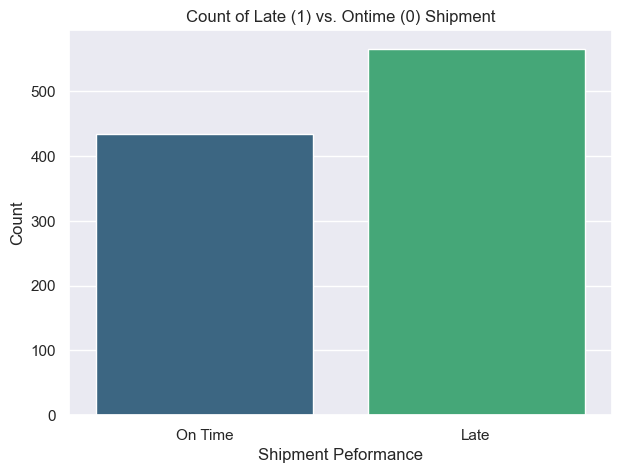

In [32]:
# Visualize the Logistcs_Delay target variable
# Compare the number of shipment late (Logistic_Delay = 1) and on Time (Logistic_Delay = 0)
plt.figure(figsize=(7, 5))
sns.countplot(x='Logistics_Delay', data=log, hue = 'Logistics_Delay', legend = False, palette='viridis')
plt.title('Count of Late (1) vs. Ontime (0) Shipment')
plt.xlabel('Shipment Peformance')
plt.ylabel('Count')
plt.xticks(np.arange(2), ('On Time', 'Late'))
plt.show()

C:\Users\nsk_z\AppData\Local\Temp\ipykernel_26964\2040243517.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Shipment_Status', data=log, legend = False, palette='viridis')


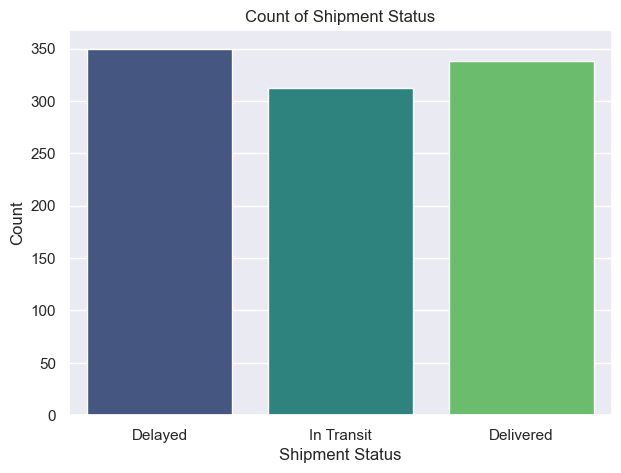

In [33]:
# Check other Category Variables
# Check 'Shipment_Status'
plt.figure(figsize=(7, 5))
sns.countplot(x='Shipment_Status', data=log, legend = False, palette='viridis')
plt.title('Count of Shipment Status')
plt.xlabel('Shipment Status')
plt.ylabel('Count')
plt.show()

C:\Users\nsk_z\AppData\Local\Temp\ipykernel_26964\3582624366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Traffic_Status', data=log, legend = False, palette='viridis')


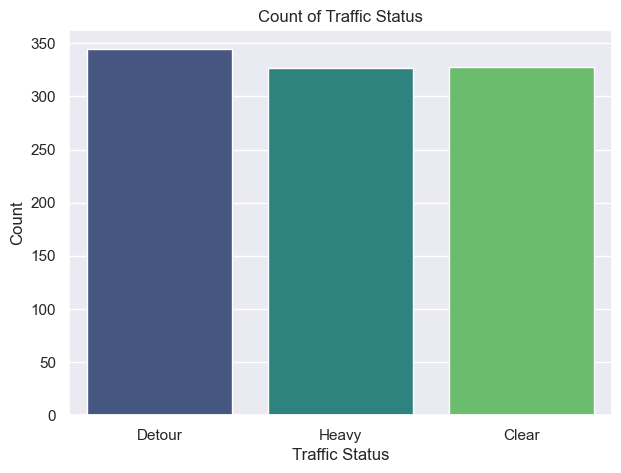

In [34]:
# Check 'Traffic_Status'
plt.figure(figsize=(7, 5))
sns.countplot(x='Traffic_Status', data=log, legend = False, palette='viridis')
plt.title('Count of Traffic Status')
plt.xlabel('Traffic Status')
plt.ylabel('Count')
plt.show()

C:\Users\nsk_z\AppData\Local\Temp\ipykernel_26964\3131914636.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Logistics_Delay_Reason', data=log, legend = False, palette='viridis')


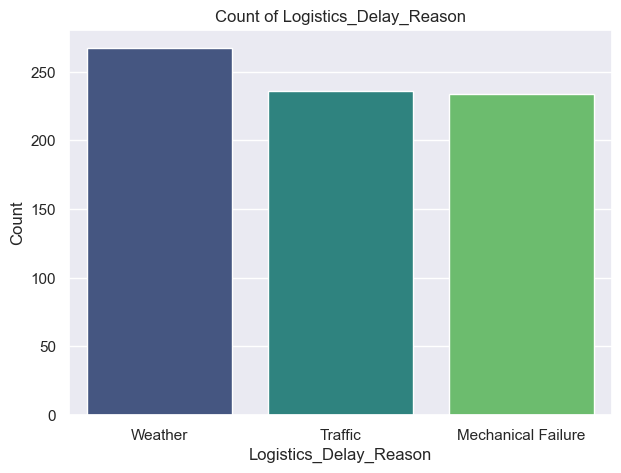

In [35]:
# Check 'Logistics_Delay_Reason'
plt.figure(figsize=(7, 5))
sns.countplot(x='Logistics_Delay_Reason', data=log, legend = False, palette='viridis')
plt.title('Count of Logistics_Delay_Reason')
plt.xlabel('Logistics_Delay_Reason')
plt.ylabel('Count')
plt.show()

In [36]:
# Inspect all the Category Variables
cat_cols = log.select_dtypes(include='object').columns
for col in cat_cols:
    print(f'\nValue counts for: {col}')
    print(log[col].value_counts())


Value counts for: Asset_ID
Asset_ID
Truck_8     109
Truck_4     107
Truck_10    105
Truck_2     105
Truck_6     103
Truck_7     102
Truck_9      94
Truck_3      93
Truck_5      93
Truck_1      89
Name: count, dtype: int64

Value counts for: Shipment_Status
Shipment_Status
Delayed       350
Delivered     338
In Transit    312
Name: count, dtype: int64

Value counts for: Traffic_Status
Traffic_Status
Detour    345
Clear     328
Heavy     327
Name: count, dtype: int64

Value counts for: Logistics_Delay_Reason
Logistics_Delay_Reason
Weather               267
Traffic               236
Mechanical Failure    234
Name: count, dtype: int64


In [37]:
# Show correlation of numeric Value
corr_matrix = log.corr(numeric_only = True)
print(f"Correlation Matrix (Pairwise): \n {corr_matrix}")

Correlation Matrix (Pairwise): 
                          Inventory_Level  Temperature  Humidity  Waiting_Time  \
Inventory_Level                 1.000000    -0.021061  0.013395     -0.020337   
Temperature                    -0.021061     1.000000 -0.022674      0.017392   
Humidity                        0.013395    -0.022674  1.000000      0.029030   
Waiting_Time                   -0.020337     0.017392  0.029030      1.000000   
User_Transaction_Amount        -0.036785    -0.006377 -0.034828     -0.017796   
User_Purchase_Frequency        -0.019701    -0.017139  0.023341      0.023582   
Asset_Utilization               0.017041     0.046005 -0.030637      0.018008   
Demand_Forecast                -0.016727    -0.010425 -0.005887     -0.030042   
Logistics_Delay                -0.003340    -0.038067 -0.000504     -0.063036   

                         User_Transaction_Amount  User_Purchase_Frequency  \
Inventory_Level                        -0.036785                -0.019701   
Te

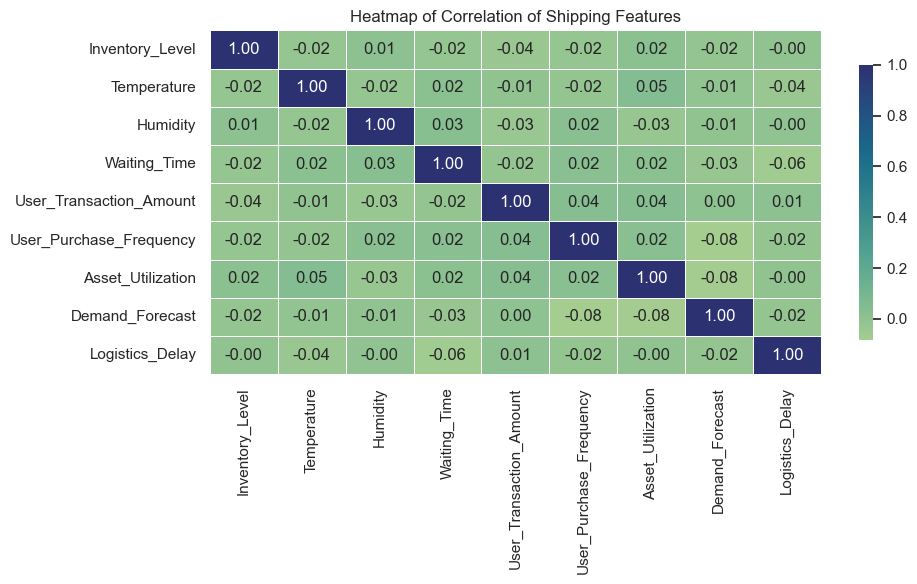

In [38]:
# plot the heatmap of correlation
sns.heatmap(
    corr_matrix,
    annot = True, # Displaying correlation value inside the heatmap cells
    cmap = 'crest',
    fmt = '.2f', # Displaying 2 decimal correlation value
    linewidth = 0.5,
    cbar_kws={"shrink": 0.8} #Shrink the colorbar to fit better
)

# Display the plot
plt.title('Heatmap of Correlation of Shipping Features')
plt.tight_layout()
plt.show()

### ***Note:*** The correlation between numerical variables are low

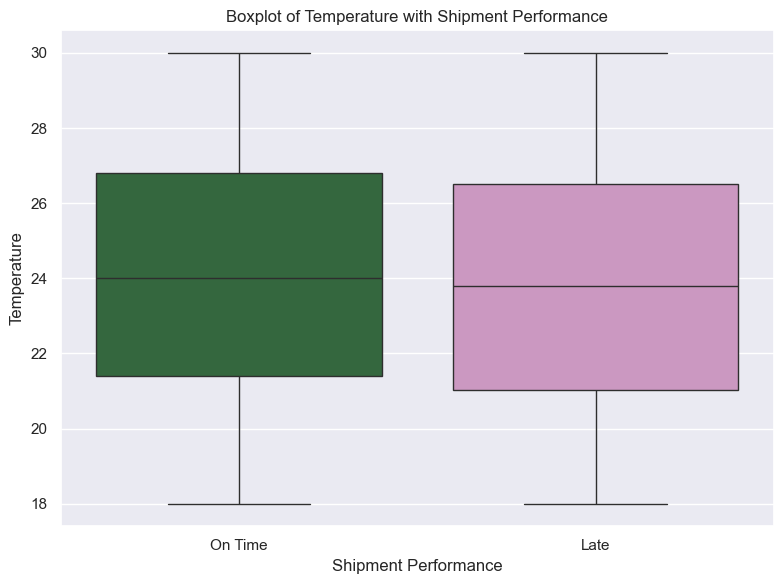

In [48]:
# Check Temperature distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Temperature', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Temperature with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Temperature')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

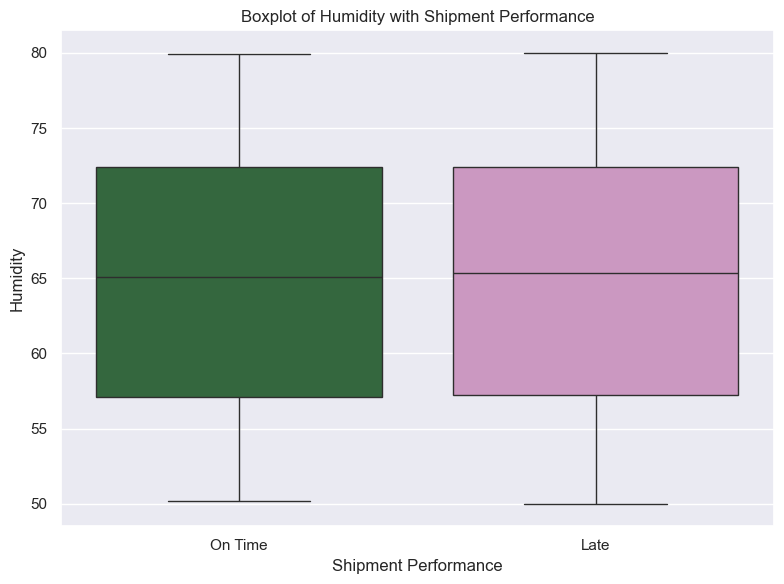

In [55]:
# Check Humidity distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Humidity', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Humidity with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Humidity')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

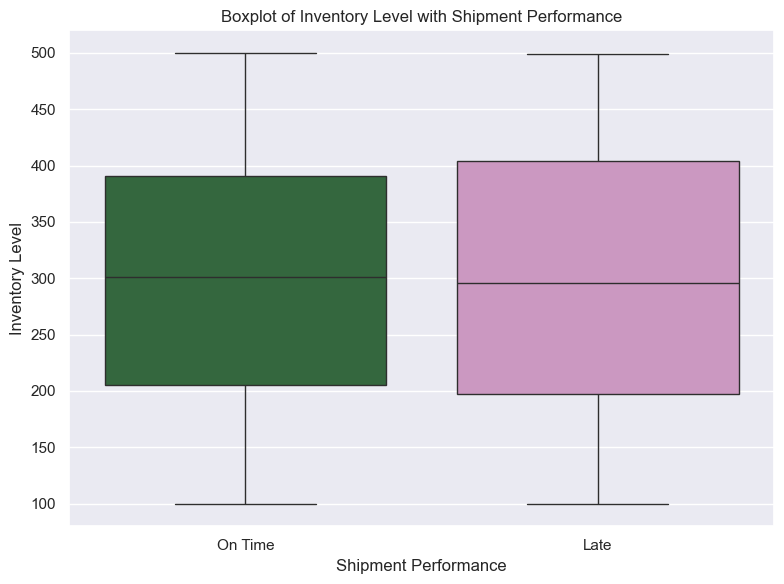

In [56]:
# Check Inventory Level distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Inventory_Level', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Inventory Level with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Inventory Level')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

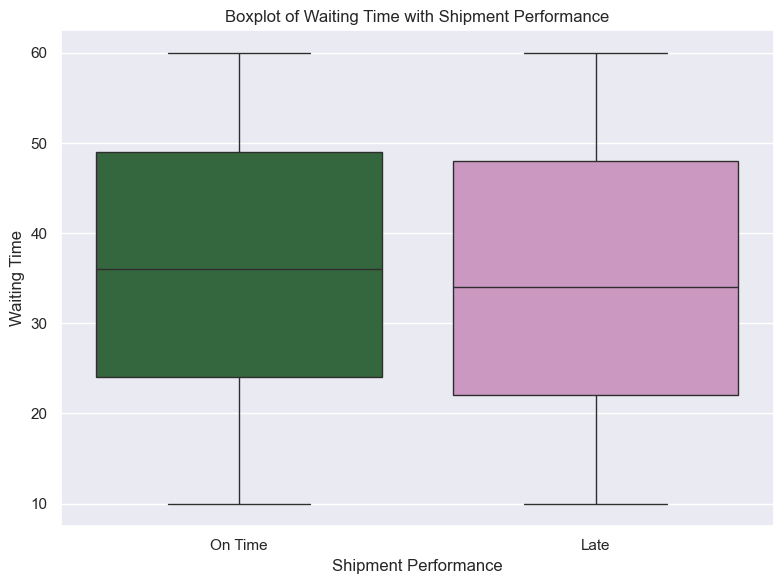

In [57]:
# Check Waiting Time distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Waiting_Time', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Waiting Time with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Waiting Time')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

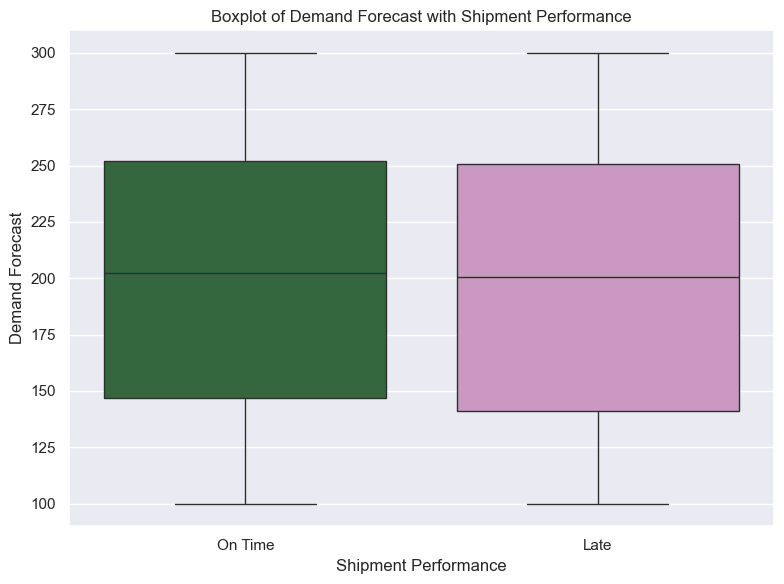

In [58]:
# Check Demand Forecast distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Demand_Forecast', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Demand Forecast with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Demand Forecast')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

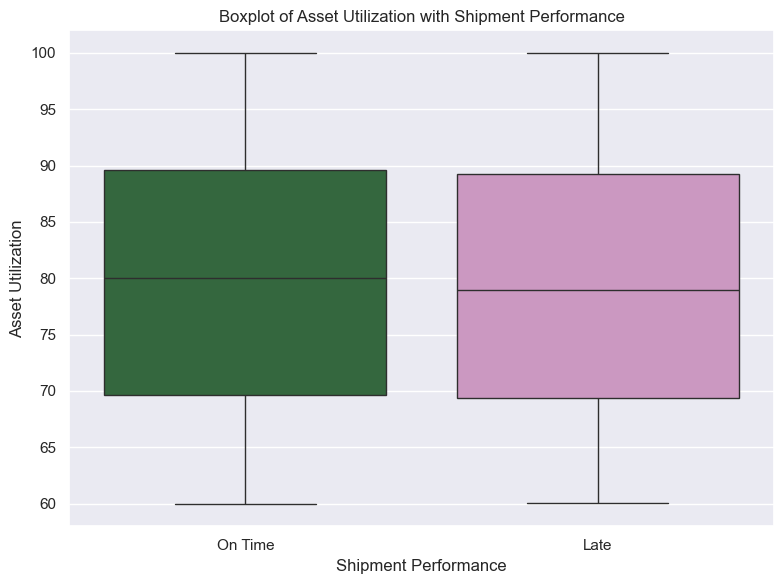

In [59]:
# Check Asset Utilization distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Logistics_Delay', y='Asset_Utilization', hue='Logistics_Delay', legend=False, data=log, palette='cubehelix')

#Add title and labels
plt.title('Boxplot of Asset Utilization with Shipment Performance')
plt.xlabel('Shipment Performance')
plt.ylabel('Asset Utilization')
plt.xticks(np.arange(2), ('On Time', 'Late'))

#Display Plot
plt.tight_layout() # prevent labels overlapping
plt.show()

### *Modelling*

In [68]:
# Assign Target Variables and Predictor
y = log['Logistics_Delay']
X = log.drop(columns=['Logistics_Delay'])

In [70]:
# Split the dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [72]:
X_train

,Asset_ID,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast
96,Truck_6,297,Delayed,23.1,59.4,Detour,29,268,10,Traffic,71.2,151
792,Truck_3,167,Delayed,21.6,54.6,Clear,46,240,10,Weather,60.5,278
218,Truck_3,290,In Transit,20.5,51.4,Clear,22,170,4,Mechanical Failure,74.7,147
967,Truck_6,309,In Transit,20.2,65.8,Detour,26,105,9,Mechanical Failure,60.7,244
170,Truck_4,378,Delayed,28.2,70.2,Clear,60,490,9,Traffic,66.8,166
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Truck_4,454,Delayed,21.0,77.3,Clear,15,112,10,Weather,73.2,237
53,Truck_8,430,Delayed,26.4,68.4,Heavy,16,277,8,NaN,71.9,137
294,Truck_8,399,Delivered,26.3,79.4,Detour,25,476,4,Mechanical Failure,95.6,256
723,Truck_7,283,Delayed,19.6,75.5,Heavy,49,496,6,Weather,78.9,130


### *Logistic Regression*

In [78]:
# Perform One Hot Encoding --> Scaling/Normalizing --> Model fitting
# Define preprocessing. Shipment_Status is excluded from training the model because is not logical to use for delay prediction.
numeric_features = ['Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast']
categorical_features = ['Traffic_Status', 'Logistics_Delay_Reason','Asset_ID']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Create the pipeline
lr_model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression())
])

# Fit only on training data
lr_model_pipeline.fit(X_train, y_train)

# Evaluate on test data
y_pred = lr_model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


In [79]:
con_mat = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(con_mat, columns = ['predicted_ontime', 'predicted_delayed'], index = ['is_ontime', 'is_delayed'])
confusion

,predicted_ontime,predicted_delayed
is_ontime,104,21
is_delayed,64,111


### *Check the features that important*

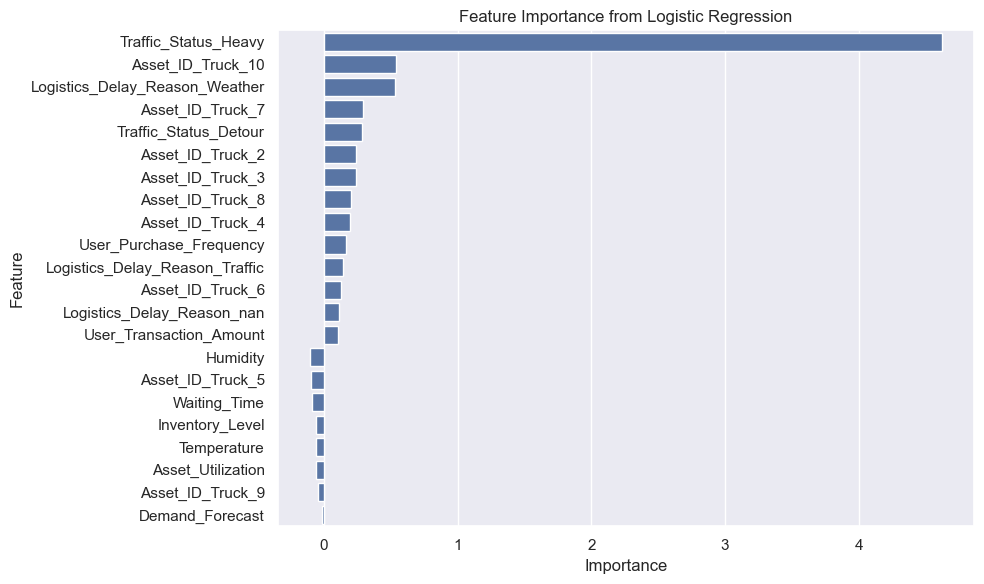

In [82]:
# First, get the feature names after one-hot encoding
ohe = lr_model_pipeline.named_steps['preprocessing'].named_transformers_['cat']
num_features = numeric_features
cat_features = ohe.get_feature_names_out(categorical_features)

all_feature_names = list(num_features) + list(cat_features)

# Then, access the model inside the pipeline and get the coefficients
model = lr_model_pipeline.named_steps['model']
importances = model.coef_[0]  # for binary classification

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Logistic Regression')
plt.tight_layout()
plt.show()

### *Support Vector Machine*

In [84]:
# Assign Target Variables and Predictor
y = log['Logistics_Delay']
X = log.drop(columns=['Logistics_Delay'])

In [86]:
# Split the dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [87]:
X_train

,Asset_ID,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast
96,Truck_6,297,Delayed,23.1,59.4,Detour,29,268,10,Traffic,71.2,151
792,Truck_3,167,Delayed,21.6,54.6,Clear,46,240,10,Weather,60.5,278
218,Truck_3,290,In Transit,20.5,51.4,Clear,22,170,4,Mechanical Failure,74.7,147
967,Truck_6,309,In Transit,20.2,65.8,Detour,26,105,9,Mechanical Failure,60.7,244
170,Truck_4,378,Delayed,28.2,70.2,Clear,60,490,9,Traffic,66.8,166
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Truck_4,454,Delayed,21.0,77.3,Clear,15,112,10,Weather,73.2,237
53,Truck_8,430,Delayed,26.4,68.4,Heavy,16,277,8,NaN,71.9,137
294,Truck_8,399,Delivered,26.3,79.4,Detour,25,476,4,Mechanical Failure,95.6,256
723,Truck_7,283,Delayed,19.6,75.5,Heavy,49,496,6,Weather,78.9,130


In [88]:
# Perform One Hot Encoding --> Scaling/Normalizing --> Model fitting
# Define preprocessing. Shipment_Status is excluded from training the model because is not logical to use for delay prediction.
numeric_features = ['Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast']
categorical_features = ['Traffic_Status', 'Logistics_Delay_Reason','Asset_ID']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Create the pipeline
svm_model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVC(random_state = 123, probability = True))
])

# Fit only on training data
svm_model_pipeline.fit(X_train, y_train)

# Evaluate on test data
y_pred = svm_model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [90]:
con_mat = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(con_mat, columns = ['predicted_ontime', 'predicted_delayed'], index = ['is_ontime', 'is_delayed'])
confusion

,predicted_ontime,predicted_delayed
is_ontime,118,7
is_delayed,63,112


### *Naive Bayes*

In [94]:
# Assign Target Variables and Predictor
y = log['Logistics_Delay']
X = log.drop(columns=['Logistics_Delay'])

In [96]:
# Split the dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [98]:
X_train

,Asset_ID,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast
96,Truck_6,297,Delayed,23.1,59.4,Detour,29,268,10,Traffic,71.2,151
792,Truck_3,167,Delayed,21.6,54.6,Clear,46,240,10,Weather,60.5,278
218,Truck_3,290,In Transit,20.5,51.4,Clear,22,170,4,Mechanical Failure,74.7,147
967,Truck_6,309,In Transit,20.2,65.8,Detour,26,105,9,Mechanical Failure,60.7,244
170,Truck_4,378,Delayed,28.2,70.2,Clear,60,490,9,Traffic,66.8,166
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Truck_4,454,Delayed,21.0,77.3,Clear,15,112,10,Weather,73.2,237
53,Truck_8,430,Delayed,26.4,68.4,Heavy,16,277,8,NaN,71.9,137
294,Truck_8,399,Delivered,26.3,79.4,Detour,25,476,4,Mechanical Failure,95.6,256
723,Truck_7,283,Delayed,19.6,75.5,Heavy,49,496,6,Weather,78.9,130


In [99]:
# Perform One Hot Encoding --> Scaling/Normalizing --> Model fitting
# Define preprocessing. Shipment_Status is excluded from training the model because is not logical to use for delay prediction.
numeric_features = ['Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast']
categorical_features = ['Traffic_Status', 'Logistics_Delay_Reason','Asset_ID']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Create the pipeline
nb_model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GaussianNB())
])

# Fit only on training data
nb_model_pipeline.fit(X_train, y_train)

# Evaluate on test data
y_pred = nb_model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [103]:
con_mat = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(con_mat, columns = ['predicted_ontime', 'predicted_delayed'], index = ['is_ontime', 'is_delayed'])
confusion

,predicted_ontime,predicted_delayed
is_ontime,125,0
is_delayed,69,106


### *Support Vector Machine with Parameter tuning*

In [107]:
# Assign Target Variables and Predictor
y = log['Logistics_Delay']
X = log.drop(columns=['Logistics_Delay'])

In [108]:
# Split the dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [111]:
X_train

,Asset_ID,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast
96,Truck_6,297,Delayed,23.1,59.4,Detour,29,268,10,Traffic,71.2,151
792,Truck_3,167,Delayed,21.6,54.6,Clear,46,240,10,Weather,60.5,278
218,Truck_3,290,In Transit,20.5,51.4,Clear,22,170,4,Mechanical Failure,74.7,147
967,Truck_6,309,In Transit,20.2,65.8,Detour,26,105,9,Mechanical Failure,60.7,244
170,Truck_4,378,Delayed,28.2,70.2,Clear,60,490,9,Traffic,66.8,166
...,...,...,...,...,...,...,...,...,...,...,...,...
204,Truck_4,454,Delayed,21.0,77.3,Clear,15,112,10,Weather,73.2,237
53,Truck_8,430,Delayed,26.4,68.4,Heavy,16,277,8,NaN,71.9,137
294,Truck_8,399,Delivered,26.3,79.4,Detour,25,476,4,Mechanical Failure,95.6,256
723,Truck_7,283,Delayed,19.6,75.5,Heavy,49,496,6,Weather,78.9,130


In [114]:
# Perform One Hot Encoding --> Scaling/Normalizing --> Model fitting
# Define preprocessing. Shipment_Status is excluded from training the model because is not logical to use for delay prediction.
numeric_features = ['Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast']
categorical_features = ['Traffic_Status', 'Logistics_Delay_Reason','Asset_ID']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Create the pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVC(random_state = 123, probability = True))
])

svc_params = {
    'model__C': [1, 10, 100],
    'model__gamma': [0.001, 0.0001],
    'model__kernel': ['linear','rbf']
}

grid_search_svm = GridSearchCV(estimator=model_pipeline,
                               param_grid=svc_params,
                               cv=5,                 # 5-fold cross-validation
                               scoring='roc_auc',    # Optimize for Area Under ROC Curve
                               n_jobs=-1,            # Use all available CPU cores
                               verbose=1)            # Show progress

# Fit only on training data
grid_search_svm.fit(X_train, y_train)

# Evaluate on test data
print("Best parameters: ", grid_search_svm.best_params_)
print("Best cross-validation score: ", grid_search_svm.best_score_)
best_model = grid_search_svm.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'model__C': 10, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best cross-validation score:  0.7870154343221303
Accuracy: 0.77


### *Plot ROC Curve for Logistic Regression, SVM, Naive Bayes and SVM with Parameter tuning & Cross validation*

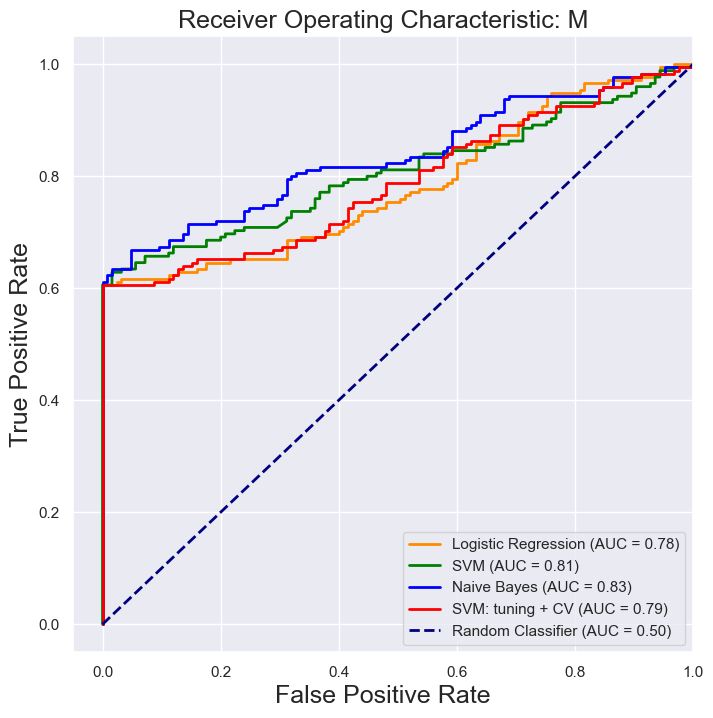

In [122]:
# For Logistic Regression
lr_probs = lr_model_pipeline.predict_proba(X_test)[:, 1]

# For SVM
svm_probs = svm_model_pipeline.predict_proba(X_test)[:, 1]

# For Naive Bayes
nb_probs = nb_model_pipeline.predict_proba(X_test)[:, 1]

# For SVM with cross validation and parameter tuning
svm_cv_probs = best_model.predict_proba(X_test)[:, 1]

# --- 4. Calculate FPR, TPR, and AUC for Each Model ---
plt.figure(figsize=[8,8])

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs, pos_label=1)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs, pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs, pos_label=1)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# SVM with cross validation and parameter tuning
fpr_svm_cv, tpr_svm_cv, _ = roc_curve(y_test, svm_cv_probs, pos_label=1)
roc_auc_svm_cv = auc(fpr_svm_cv, tpr_svm_cv)

# Plot ROC curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, color='green', lw=2,
         label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Plot ROC curve for Naive Bayes
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2,
         label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

# Plot ROC curve for SVN with cross validation and parameter tuning
plt.plot(fpr_svm_cv, tpr_svm_cv, color='red', lw=2,
         label=f'SVM: tuning + CV (AUC = {roc_auc_svm_cv:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### ***Note:*** Comparison with 4 models:
#### *The Models:*
- **Logistic Regression:** Accuracy: 0.72, AUC: 0.78
- **SVM:** Accuracy: 0.77, AUC: 0.81
- **Naive Bayes:** Accuracy: 0.77, AUC: 0.83
- **SVM with parameter tuning & cross validation:** Acccuracy: 0.77, AUC: 0.79
### **Naive Bayes selected as best prediction model**



<Figure size 800x800 with 0 Axes>

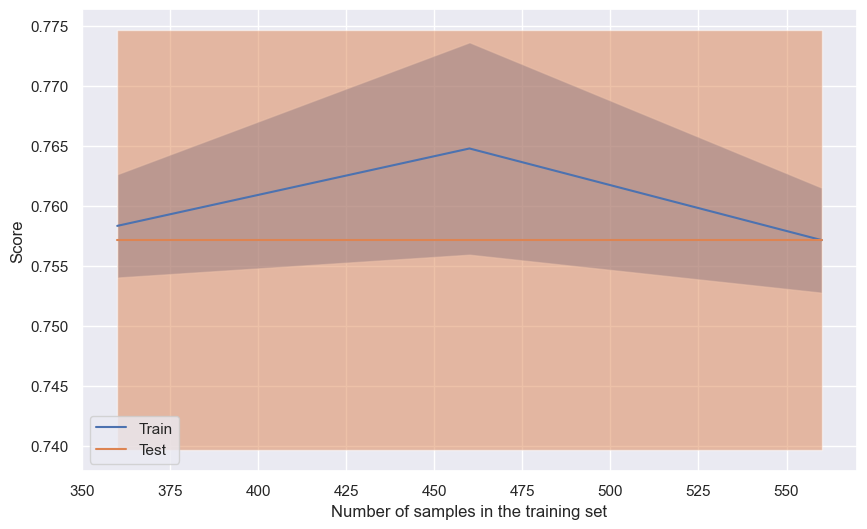

In [128]:
# Plot the learning curve to understand whether increase training size will help to improve the score of Naive Bayes
plt.figure(figsize=[8,8])
LearningCurveDisplay.from_estimator(
   nb_model_pipeline, X_train, y_train, train_sizes=[360, 460, 560], cv=5)
plt.show()

### ***Note:*** Increase size of training set will not help to improve the model score
